In [1]:
import sympy 
sympy.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control


import scipy.optimize
from tbcontrol.responses import fopdt, sopdt
from ipywidgets import interact

def resultplot1(K, tau, theta, y0):
    plt.figure(figsize=(21, 7))
    plt.scatter(ts, ym)
    plt.plot(ts, fopdt(ts, K, tau, theta, y0), color='red')
    plt.grid(True)

def resultplot2(K, tau, zeta, theta, y0):
    plt.figure(figsize=(21, 7))
    plt.scatter(ts, ym)
    plt.plot(ts, sopdt(ts, K, tau, zeta,theta, y0), color='red')
    plt.grid(True)

# PID

El controlador PID se compone de:
- Una acción Proporcional para prindar velocidad de respuesta y disminuir el error de estado estable
- Una acción Integral para eliminar el error de estado estable
- Una acción Derivativa para encargarse de errores cuando hay un cambio en el valor absoluto del error teniendo en cuenta que si el error es constante, solo actúan los modos proporcional e integral. 

La función de transferencia del PID es:

$$K_C\left ( 1 + \frac{1}{\tau_I s}+ \tau_D s \right )$$

La forma anterior no es realizable debido a la acción derivativa. Por esta razon, es común usar la forma:

$$K_C\left ( 1 + \frac{1}{\tau_I s}+ \frac{\tau_D s}{\alpha \tau_I s+1} \right )$$

donde se escoge $\alpha$ de manera que la parte derivativa sea una "buena" aproximación de la derivada.



## Diseño directo

Esta técnica parte del supuesto de definir el comportamiento deseado para el sistema en lazo cerrado, escribir una función de transferencia de lazo cerrado de una forma apropiada y despejar el compensador

<img src="figuras/standard_feedback.png" width=500em>

Partiendo del diagrama anterior, se define la relación deseada para $\frac{Y}{Y_{SP}}$ considerando $D=0$. Después se despeja $G_C$.

In [2]:
s, G_C = sympy.symbols('s, G_C')
G_C

Se parte de un modelo de primer orden más tiempo muerto como expresión deseada de $\frac{Y}{Y_{SP}}$.

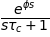

In [3]:
tau_c, phi = sympy.symbols('tau_c, phi', positive=True, nonzero=True)
desired_Y_over_Y_sp = sympy.exp(phi*s)/(tau_c*s + 1)
desired_Y_over_Y_sp

Recuerde la forma de la respuesta del sistema ante un escalón.

In [4]:
from ipywidgets import interact
t = sympy.Symbol('t', positive=True)
def plotresponse(theta=(0, 3.), tau_c_in=(1., 5.)):
    desired_response = sympy.inverse_laplace_transform(desired_Y_over_Y_sp.subs({phi: -theta, tau_c: tau_c_in})/s, s, t)
    p = sympy.plot(desired_response, (t, 0, 10), show=False)
    p2 = sympy.plot(1, (t, 0, 10), show=False)
    p.append(p2[0])
    p.show()
interact(plotresponse);

interactive(children=(FloatSlider(value=1.5, description='theta', max=3.0), FloatSlider(value=3.0, description…

A partir de un modelo aproximado para el proceso $\widetilde{G_P}$, puede calcularse la función de transferencia de lazo cerrado.

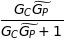

In [5]:
GPtilde = sympy.Symbol(r'\widetilde{G_P}')
actual_Y_over_Y_sp = GPtilde*G_C/(1 + GPtilde*G_C)
actual_Y_over_Y_sp

En este punto, podría encontrarse el compensador al resolver la igualdad con la función de transferencia  deseada para el sistema en lazo cerrado.

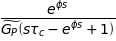

In [6]:
G_C_solved, = sympy.solve(desired_Y_over_Y_sp - actual_Y_over_Y_sp, G_C)
G_C_solved

Esta función de transferencia tiene $e^{\phi s}$ en el numerador y en el denominador.  
- El significado de la exponencial en el numerador es de desplazamiento temporal (tiempo muerto).
- El denominador se aproxima mediante una expansión de serie de Taylor de primer orden.

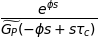

In [7]:
denom = sympy.denom(G_C_solved)
G_C_rational = G_C_solved*denom/denom.subs(sympy.exp(phi*s), 1 + phi*s)
G_C_rational

Se define la forma para el compensador PID

$$K_C\left ( 1 + \frac{1}{\tau_I s}  + \tau_D s      \right )$$

In [8]:
K_C, tau_I, tau_D = sympy.symbols('K_C, tau_I, tau_D', positive=True, nonzero=True)
PID = K_C*(1 + 1/(tau_I*s) + tau_D*s)
PID.expand().together()

Aunque la forma anterior no es realizable debido a la acción derivativa. Por esta razon, es común usar la forma:

$$K_C\left ( 1 + \frac{1}{\tau_I s}+ \frac{\tau_D s}{\alpha \tau_I s+1} \right )$$

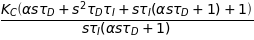

In [9]:
alpha = sympy.symbols('alpha')
ISA = K_C*(1 + 1/(tau_I*s) + tau_D*s/(alpha*tau_D*s + 1))
ISA.expand().together().simplify()

El objetivo es hallar los parámetros del compensador para satisfacer la expresión racional $G_C$

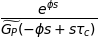

In [10]:
G_C_rational

Se requiere un modelo de proceso $G$. En este ejemplo se usará un modelo de segundo orden con tiempo muerto.

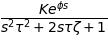

In [11]:
K, tau, zeta, phi,= sympy.symbols('K, tau, zeta, phi', positive=True)
G2 = K*sympy.exp(phi*s)/((tau*s)**2 + 2*tau*zeta*s + 1)
G2

Se incorpora el modelo del sistema a la expresión del compensador.

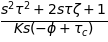

In [12]:
target_G_C = G_C_rational.subs(GPtilde, G2).expand().together()
target_G_C

Se buscan los parámetros del PID que conformen el compensador despejado.

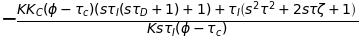

In [13]:
# diferencia entre compensadores determinados
zeroeq = (target_G_C - PID).simplify()
zeroeq

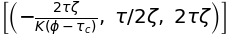

In [14]:
numer, denom = zeroeq.as_numer_denom()
eq = sympy.poly(numer, s)
eqs = eq.coeffs()
sympy.solve(eqs, [K_C, tau_D, tau_I])

La solución obtenida muestra:

$$K_C = -\frac{2\tau \zeta}{K(\phi-\tau_C)}$$
$$\tau_D = \frac{\tau}{2\zeta}$$
$$\tau_I = 2\tau\zeta$$


Los parámetros del compensador quedan completamente definidos a partir de un modelo aproximado del proceso

$$\frac{K}{(\tau s)^2 + 2\tau \zeta s + 1} \cdot e^{s\phi}$$

Y una respuesta deseada

$$\frac{e^{\phi s}}{\tau_c s + 1}$$

**Ejemplo**

Ajuste un controlador PID para un sistema que fue excitado con un escalón unitario y su respuesta fue registrada.

In [15]:
GP = control.tf([1, 2], [2, 3, 4, 1])
GP
df = pd.read_csv('Datos\DatoEscalon.csv')
df.head()

,Unnamed: 0,tiempo,U,Y
0,0,0.000000,1.0,5.011953
1,1,0.196392,1.0,5.050839
2,2,0.392785,1.0,5.101922
3,3,0.589177,1.0,4.996570
4,4,0.785569,1.0,5.060810


In [16]:
ym = df.Y
ts = df.tiempo
interact(resultplot2, K=(0., 4.), tau=(0., 2.), 
         theta=(0., 2.), zeta = (0, 2.0), y0=(0., 10.));

interactive(children=(FloatSlider(value=2.0, description='K', max=4.0), FloatSlider(value=1.0, description='ta…

In [17]:
p_inicial = [2, 1, 1.1, 0.5, 4.9]
[K_2, tau_2, zeta_2, theta_2, y0_2], pcov = scipy.optimize.curve_fit(sopdt, ts, ym, p_inicial)
[K_2, tau_2, zeta_2, theta_2, y0_2]

C:\Users\Usuario\.conda\envs\SistDin\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: overflow encountered in cosh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\.conda\envs\SistDin\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


Se define el comportamiento deseado.

In [18]:
tauC = 1.5

Se calculan los parámetros del PID 

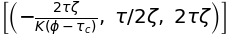

In [19]:
sympy.solve(eqs, [K_C, tau_D, tau_I])

In [20]:
KC = -2*tau_2*zeta_2/(K_2*(-theta_2 - tauC))
TD = tau_2/(2*zeta_2)
TI = 2*tau_2*zeta_2
[KC,TI,TD]

In [21]:
PID1 = KC*(1 + 1/(TI*s) + TD*s)
PID1.expand().together()

In [22]:
GC_PID1 = KC*(1 + control.tf(1,[TI,0]) + control.tf([TD,0],1))
GC_PID1

TransferFunction(array([0.02547935, 1.67188322, 0.62270883]), array([2.68485549, 0.        ]))

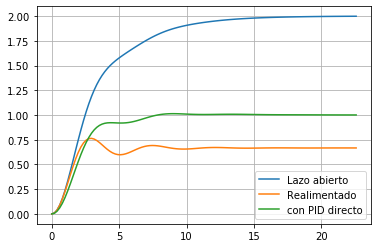

In [23]:
_, yLA = control.step_response(GP,ts)
_, yLC1 = control.step_response(control.feedback(GP,1),ts)
_, yLCPID = control.step_response(control.feedback(GC_PID1*GP,1),ts)

plt.plot(ts,yLA,
         ts,yLC1,
         ts,yLCPID)
plt.legend(('Lazo abierto','Realimentado','con PID directo'))
plt.grid()


Observe que se presentan oscilaciones aunque la respuesta deseada se modeló como un sistema de primer orden con tiempo muerto. 

- ¿A qué se debe esta discrepancia?
- ¿Qué puntos débiles puede tener esta metodología?

------

## Reglas de sintonía

En procesos sobreamortiguados de orden elevado se obtienen respuestas características en forma de **S**. [Ziegler y Nichols](https://controlautomaticoeducacion.com/control-realimentado/ziegler-nichols-sintonia-de-control-pid/)